In [3]:
import numpy as np
import pycbc
import matplotlib.pyplot as plt
from pycbc.psd import aLIGOAPlusDesignSensitivityT1800042
from pycbc.waveform import get_fd_waveform, get_waveform_filter_length_in_time as chirplen
from pycbc.filter.matchedfilter import overlap, match
from tqdm import tqdm
from pycbc.conversions import mass1_from_tau0_tau3, mass2_from_tau0_tau3, tau0_from_mass1_mass2, tau3_from_mass1_mass2
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
from pycbc.types.frequencyseries import FrequencySeries
from scipy.interpolate import griddata
import matplotlib.colors as mcolors

In [4]:
def get_wf(params):
    try:
        # sanity checks for physical masses
        if params['mass1'] <= 0 or params['mass2'] <= 0:
            return None
        wf, _ = get_fd_waveform(template=None, **params)

        if len(wf) != Nf:  # resize if needed
            wf.resize(Nf)
        return wf
    except Exception as e:
        # catch errors from waveform generation
        return None

$$
\tau_0 = \frac{\theta_0}{2 \pi f_{\text{low}}}
$$

$$
\tau_3 = \frac{\theta_3}{2 \pi f_{\text{low}}}
$$

In [5]:
def m1_m2f_theta03(theta0, theta3):
    
    tau0 = theta0 / (2 * np.pi * flow)
    tau3 = theta3 / (2 * np.pi * flow)
    
    m1 = mass1_from_tau0_tau3(tau0, tau3, flow)
    m2 = mass2_from_tau0_tau3(tau0, tau3, flow)
    
    return m1, m2

In [6]:
def theta03(m1, m2, flow):
    tau0 = tau0_from_mass1_mass2(m1, m2, flow)
    tau3 = tau3_from_mass1_mass2(m1, m2, flow)
    theta0 = 2 * np.pi * flow * tau0
    theta3 = 2* np.pi * flow * tau3
    return theta0, theta3

$$
\Gamma_{ij} = \left( \frac{\partial h}{\partial \theta_i} \,\middle|\, \frac{\partial h}{\partial \theta_j} \right)
$$

with the inner product defined as  

$$
(a|b) = 4 \, \Re \int_{f_{\text{low}}}^{f_{\text{high}}} \frac{\tilde{a}(f) \, \tilde{b}^*(f)}{S_n(f)} \, df \, ,
$$


##### Using finite difference formula to calculate the deravatives 
$$
f'(x) \approx \frac{f(x+h) - f(x-h)}{2h} + \mathcal{O}(h^2)
$$

In [7]:
def fisher_matrix(params, Nf, psd, steps, keys=['dtheta0', 'dtheta3', 'tc', 'phi0']):
    hp = get_wf(params)
    f = hp.sample_frequencies

    flow = params['f_lower']

    A = np.abs(hp)  # Amplitude
    norm_hp = overlap(hp, hp, psd, flow, fhigh, normalized=False)

    m1 = params['mass1']
    m2 = params['mass2']

    theta0, theta3 = theta03(m1, m2, flow)

    derivs_phi = {}
    derivs_amp = {}

    for key in keys:
        dp = steps.get(key)

        if key == 'dtheta0':
            # candidate points
            theta_plus = theta0 + dp
            theta_minus = theta0 - dp

            m1_plus, m2_plus = m1_m2f_theta03(theta_plus, theta3)
            m1_minus, m2_minus = m1_m2f_theta03(theta_minus, theta3)

            valid_plus = (not np.iscomplex(m1_plus) and not np.iscomplex(m2_plus)
                          and m1_plus > 0 and m2_plus > 0)
            valid_minus = (not np.iscomplex(m1_minus) and not np.iscomplex(m2_minus)
                           and m1_minus > 0 and m2_minus > 0)

            if valid_plus and valid_minus:
                # central difference (preferred)
                params_plus = params.copy()
                params_minus = params.copy()
                params_plus.update({'mass1': float(m1_plus), 'mass2': float(m2_plus)})
                params_minus.update({'mass1': float(m1_minus), 'mass2': float(m2_minus)})
                use_scheme = 'central'
            elif valid_plus:
                # forward difference: (f(x+dp) - f(x)) / dp
                params_plus = params.copy()
                params_plus.update({'mass1': float(m1_plus), 'mass2': float(m2_plus)})
                params_minus = params.copy()  # central point
                use_scheme = 'forward'
            elif valid_minus:
                # backward difference: (f(x) - f(x-dp)) / dp
                params_minus = params.copy()
                params_minus.update({'mass1': float(m1_minus), 'mass2': float(m2_minus)})
                params_plus = params.copy()  # central point
                use_scheme = 'backward'
            else:
                return None  # can't compute derivative at boundary

        elif key == 'dtheta3':
            theta_plus = theta3 + dp
            theta_minus = theta3 - dp

            m1_plus, m2_plus = m1_m2f_theta03(theta0, theta_plus)
            m1_minus, m2_minus = m1_m2f_theta03(theta0, theta_minus)

            valid_plus = (not np.iscomplex(m1_plus) and not np.iscomplex(m2_plus)
                          and m1_plus > 0 and m2_plus > 0)
            valid_minus = (not np.iscomplex(m1_minus) and not np.iscomplex(m2_minus)
                           and m1_minus > 0 and m2_minus > 0)

            if valid_plus and valid_minus:
                params_plus = params.copy()
                params_minus = params.copy()
                params_plus.update({'mass1': float(m1_plus), 'mass2': float(m2_plus)})
                params_minus.update({'mass1': float(m1_minus), 'mass2': float(m2_minus)})
                use_scheme = 'central'
            elif valid_plus:
                params_plus = params.copy()
                params_plus.update({'mass1': float(m1_plus), 'mass2': float(m2_plus)})
                params_minus = params.copy()
                use_scheme = 'forward'
            elif valid_minus:
                params_minus = params.copy()
                params_minus.update({'mass1': float(m1_minus), 'mass2': float(m2_minus)})
                params_plus = params.copy()
                use_scheme = 'backward'
            else:
                return None

        elif key == 'tc':
            derivs_phi[key] = FrequencySeries(2 * np.pi * f, delta_f)
            derivs_amp[key] = FrequencySeries(np.zeros(Nf), delta_f)
            continue

        elif key == 'phi0':
            derivs_phi[key] = FrequencySeries(np.ones(Nf), delta_f)
            derivs_amp[key] = FrequencySeries(np.zeros(Nf), delta_f)
            continue

        # Now compute waveforms needed depending on scheme
        if use_scheme == 'central':
            h_plus = get_wf(params_plus)
            h_minus = get_wf(params_minus)

            phi_plus = np.unwrap(np.angle(h_plus))
            phi_minus = np.unwrap(np.angle(h_minus))

            amp_plus = np.abs(h_plus)
            amp_minus = np.abs(h_minus)

            derivs_phi[key] = (phi_plus - phi_minus) / (2 * dp)
            derivs_amp[key] = (amp_plus - amp_minus) / (2 * dp)

        elif use_scheme == 'forward':
            # f(x+dp) - f(x)
            h_plus = get_wf(params_plus)
            h0 = get_wf(params)  # central

            phi_plus = np.unwrap(np.angle(h_plus))
            phi0 = np.unwrap(np.angle(h0))

            amp_plus = np.abs(h_plus)
            amp0 = np.abs(h0)

            derivs_phi[key] = (phi_plus - phi0) / dp
            derivs_amp[key] = (amp_plus - amp0) / dp

        elif use_scheme == 'backward':
            # f(x) - f(x-dp)
            h_minus = get_wf(params_minus)
            h0 = get_wf(params)  # central

            phi_minus = np.unwrap(np.angle(h_minus))
            phi0 = np.unwrap(np.angle(h0))

            amp_minus = np.abs(h_minus)
            amp0 = np.abs(h0)

            derivs_phi[key] = (phi0 - phi_minus) / dp
            derivs_amp[key] = (amp0 - amp_minus) / dp

        else:
            # Should not happen, but guard
            return None

    # if any derivative is missing → bail
    if len(derivs_phi) < len(keys) or len(derivs_amp) < len(keys):
        return None

    # build Fisher matrix
    n = list(keys)
    k = len(n)

    F = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            key_i = n[i]
            key_j = n[j]
            t1 = overlap(A * derivs_phi[key_i], A * derivs_phi[key_j], psd, flow, fhigh, normalized=False)
            t2 = overlap(derivs_amp[key_i], derivs_amp[key_j], psd, flow, fhigh, normalized=False)
            F[i, j] = (t1 + t2) / (2 * norm_hp)

    G1 = F[0:2, 0:2]  # intrinsic- intrinsic block
    G2 = F[0:2, 2:4]  # intrinsic - extrinsic block
    G3 = F[2:4, 2:4]  # extrinsic - extrinsic block
    G4 = F[2:4, 0:2]  # extrinsic - intrinsic block
    G3_inv = np.linalg.inv(G3)
    g = G1 - G2 @ G3_inv @ G4

    return g

We initialize the intrinsic parameters for our parameter space as follows:

- Component masses:
$$
m_1 = 5.5, \quad m_2 = 1.5
$$
- These represent the **central point** of the parameter space:  
$$
m_1 \in [1, 10], \quad m_2 \in [1, 2]
$$

In [8]:
m1, m2, s1z , s2z = 5.5, 1.5, 0., 0.
fsamp, flow, fhigh = 4096, 30, 2048
kwargs = {'mass1': m1,
        'mass2': m2,
        'spin1z': s1z,
        'spin2z': s2z,
        'f_lower': flow}

In [9]:
sig_duration = chirplen(approximant = 'TaylorF2',**kwargs)
seglen = 2 ** (int(np.log2(sig_duration)) + 1)
print(f"Signal Duration : {sig_duration} s")
print(f"signal length : {seglen}")

Signal Duration : 17.447067665596432 s
signal length : 32


In [10]:
delta_f = 1./ seglen
Nt = fsamp * seglen
Nf = int(Nt/2 + 1)

In [11]:
delta_f

0.03125

In [12]:
psd = pycbc.psd.analytical.aLIGOAPlusDesignSensitivityT1800042(Nf, delta_f, flow)
psd.data[np.where(psd.data == 0)[0]] = 10**(-50)

In [22]:
params = {'approximant': "TaylorF2",
         'mass1': m1,
         'mass2': m2,
         'spin1z': s1z,
         'spin2z': s2z,
         'delta_f': delta_f,
         'f_lower': flow}

steps = {'dtheta0': 1e-5,
    'dtheta3': 1e-5, 
    'tc': 1e-3, ## dummy variation not actually use in calculation    
    'phi0': 1e-3} ## dummy variation not actually use in calculation   

In [23]:
g_ref = fisher_matrix(params,Nf, psd, steps, keys = [ 'dtheta0', 'dtheta3', 'tc', 'phi0'])

In [24]:
g_ref

array([[ 0.00700696, -0.00907585],
       [-0.00907585,  0.01284985]])

In [25]:
hp = get_wf(params)

In [26]:
def metric_pts(metric, N):
    eigvals, eigvecs = np.linalg.eig(metric)
    R = 1
    np.random.seed(0)
    x1 = np.random.rand(N)
    x2 = np.random.rand(N)
    r = R * np.sqrt(x1)
    theta = x2 * 2 * np.pi
    u1 = r * np.cos(theta)
    u2 = r * np.sin(theta)
    
    y1 = u1/ np.sqrt(eigvals[0])
    y2 = u2/ np.sqrt(eigvals[1])

    s_pts = np.vstack([y1, y2]) # scaling
    
    o = eigvecs @ s_pts # rotation
    e_pts = o.T
    
    return e_pts 

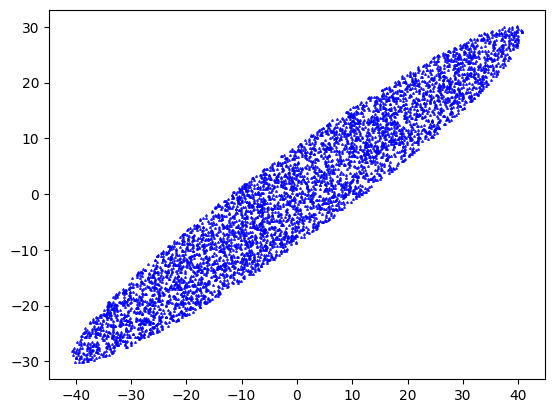

In [27]:
k = metric_pts(g_ref ,5000)
plt.scatter(k[:, 0], k[:, 1], color='b', marker='^', label='k points', s= 1)

In [28]:
cparams = params.copy()
cparams

{'approximant': 'TaylorF2',
 'mass1': 5.5,
 'mass2': 1.5,
 'spin1z': 0.0,
 'spin2z': 0.0,
 'delta_f': 0.03125,
 'f_lower': 30}

In [29]:
theta0, theta3 = theta03(m1, m2, flow)

In [30]:
theta3

212.62755783850886

In [31]:
exact_match = []

hp = get_wf(cparams)
if hp is not None:
    for i in tqdm(range(len(k))):
        dx, dy = k[i]
        params_plus = params.copy()
        theta0_plus = theta0 + dx
        theta3_plus = theta3 + dy
        
        m1_plus, m2_plus = m1_m2f_theta03(theta0_plus, theta3_plus)
        params_plus.update({"mass1": m1_plus,"mass2": m2_plus})
        hp_plus = get_wf(params_plus)  # safe waveform

        if hp_plus is not None:  # only compute match if valid
            try:
                match_val = match(hp, hp_plus, psd, flow, fhigh)[0]
                exact_match.append(match_val)
            except Exception:
                exact_match.append(0.)
        else:
            exact_match.append(0.)
        del hp_plus  # free memory each iteration
        
else:
    print("Reference waveform could not be generated.")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:44<00:00, 30.44it/s]


In [32]:
match_metric = []
for i in range(len(k)):
    t = k[i]
    m_metric =  1- (np.dot(t, np.dot(g_ref, t)))
    match_metric.append(m_metric)

In [33]:
len(exact_match)

5000

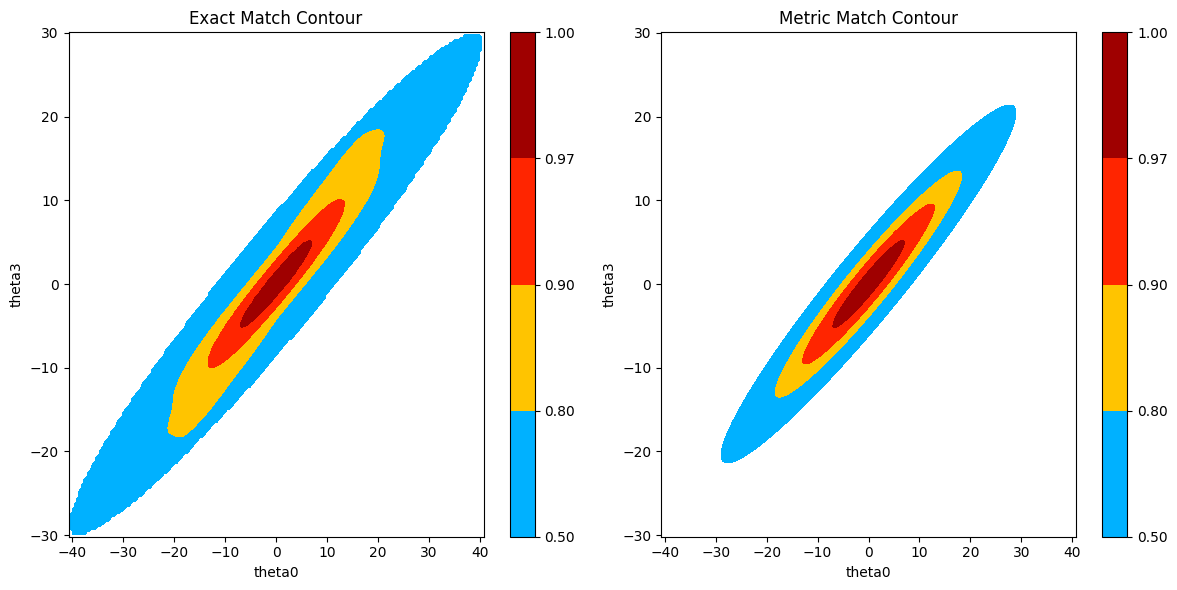

In [34]:
# Proper points array for griddata
points = np.column_stack((k[:, 0], k[:, 1]))

n = 200
x_min, x_max = k[:, 0].min(), k[:, 0].max()
y_min, y_max = k[:, 1].min(), k[:, 1].max()

x_grid = np.linspace(x_min, x_max, n)
y_grid = np.linspace(y_min, y_max, n)
X, Y = np.meshgrid(x_grid, y_grid)

# Use griddata with fill_value for NaNs
Z_exact = griddata(points, np.array(exact_match), (X, Y), method='cubic', fill_value=np.nan)
Z_metric = griddata(points, np.array(match_metric), (X, Y), method='cubic', fill_value=np.nan)

levels = [0.50, 0.80, 0.90, 0.97, 1.00]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

c1 = axs[0].contourf(X, Y, Z_exact, levels, cmap='jet')
axs[0].set_title('Exact Match Contour')
axs[0].set_xlabel('theta0')
axs[0].set_ylabel('theta3')
fig.colorbar(c1, ax=axs[0], ticks=levels)

c2 = axs[1].contourf(X, Y, Z_metric, levels, cmap='jet')
axs[1].set_title('Metric Match Contour')
axs[1].set_xlabel('theta0')
axs[1].set_ylabel('theta3')
fig.colorbar(c2, ax=axs[1], ticks=levels)

plt.tight_layout()
plt.show()

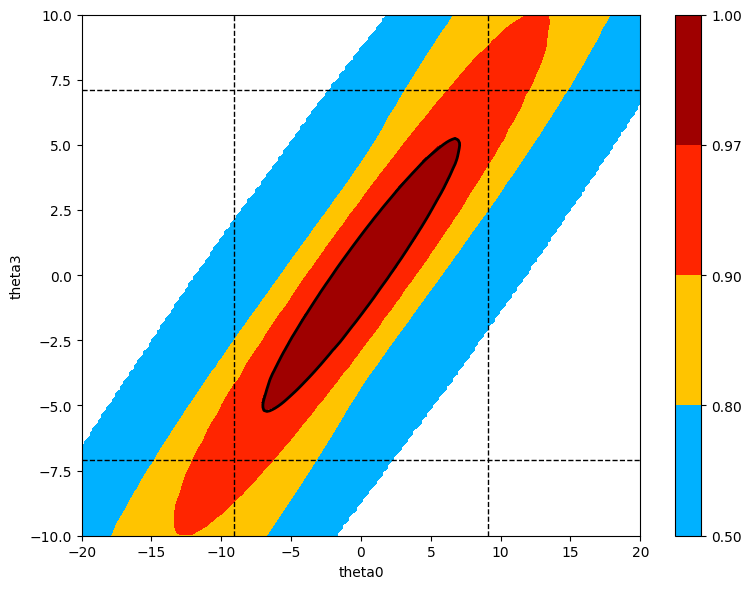

In [35]:
n = 200

x_grid = np.linspace(-20, 20, n)
y_grid = np.linspace(-10, 10, n)
X, Y = np.meshgrid(x_grid, y_grid)

Z_exact = griddata((k[:, 0], k[:, 1]), exact_match, (X,Y), method = 'cubic') 
Z_metric = griddata((k[:, 0], k[:, 1]), match_metric, (X,Y), method = 'cubic')
l = [0.50, 0.80, 0.90, 0.97, 1.00]

fig, ax = plt.subplots(figsize=(8, 6))
c1 = ax.contourf(X, Y, Z_exact, l, cmap = 'jet')
ax.set_xlabel('theta0')
ax.set_ylabel('theta3')
cbar = fig.colorbar(c1, ax = ax, ticks = l)

boundary = ax.contour(X, Y, Z_metric, levels=[0.97], colors='black', linewidths=2)
plt.axhline(y=  7.1, color='black', linestyle='--', linewidth=1, label='y=7.5' )
plt.axvline(x= 9.1, color='black', linestyle='--', linewidth=1, label='x=10')
plt.axhline(y=-7.1, color='black', linestyle='--', linewidth=1, label='y=-7.5' )
plt.axvline(x=-9.1, color='black', linestyle='--', linewidth=1, label='x=-10')
plt.tight_layout()
plt.show()